# Sources

https://github.com/thiery-lab/data-assimilation

## Model

The model is a [three-dimensional dynamical system developed as a simpified model of atmosphereic convection](https://en.wikipedia.org/wiki/Lorenz_system) by Lorenz [1] which is a classic example of chaotic non-periodic dynamics. A flow map $\varphi : \mathbb{R}_{\geq 0} \to (\mathbb{R}^3 \to \mathbb{R}^3)$ is defined such that $\boldsymbol{x}(\tau) = \varphi(\tau)(\boldsymbol{x}_0)$ where $\boldsymbol{x}(\tau), \tau > 0$ is the solution to the initial value problem
\begin{equation}
  \frac{\mathrm{d} x_0}{\mathrm{d} \tau} = \sigma (x_1 - x_0), \quad
  \frac{\mathrm{d} x_1}{\mathrm{d} \tau} = x_0 (\rho - x_2) - x_1, \quad
  \frac{\mathrm{d} x_2}{\mathrm{d} \tau} = x_0 x_1 - \beta x_2 \quad
  \text{and} \quad \boldsymbol{x}(0) = \boldsymbol{x}_0.
\end{equation}

Here we use the (standard) parameter values $\rho = 28, \sigma=10, \beta=\frac{8}{3}$ which exhibit chaotic dynamics. An implicit mid-point method is used to define an approximate flow map $\tilde{\varphi}(\Delta) \approx \varphi(\Delta)$ with time step $\Delta = 0.005$ and $S=10$ time steps per state update. The state update is $\boldsymbol{x}_t = \bigcirc_{s=1}^S \big(\tilde{\varphi}({\Delta})\big)(\boldsymbol{x}_{t-1}) + \boldsymbol{\xi}_t$ with additive noise with distribution $\boldsymbol{\xi}_t \sim \mathcal{N}(\mathbf{0}_3, 0.1^2 \mathbb{I}_3)$ and initial state distribution $\boldsymbol{x}_0 \sim \mathcal{N}(\mathbf{1}_3, 0.5^2 \mathbb{I}_3)$. The first $x_{0,t}$ component of the state is noisily observed $y_t = x_{0,t} + \epsilon_t$, with additive Gaussian noise $\epsilon_t \sim \mathcal{N}(0, 5^2)$.

References:

1. Lorenz, Edward Norton (1963). Deterministic nonperiodic flow. Journal of the Atmospheric Sciences. 20 (2): 130–141.

## Data Assimilation

In [2]:
import numpy as np
import dapy.filters as filters
from dapy.models import Lorenz1963Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100

In [3]:
model_params = {
    'sigma': 10.,
    'rho': 28.,
    'beta': 8. / 3.,
    'initial_state_mean': 1.,
    'initial_state_std': 0.5,
    'state_noise_std': 0.1,
    'observation_function':  lambda x, t: x[..., 0:1],
    'observation_noise_std': 5.,
    'time_step': 0.005,
    'num_integrator_step_per_update': 5,
}
model = Lorenz1963Model(**model_params)

### Generate data from model

In [4]:
num_observation_time = 800
observation_time_indices = np.arange(num_observation_time)
seed = 1234
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|800/800 [00:00<00:00, 7300.40time-steps/s]

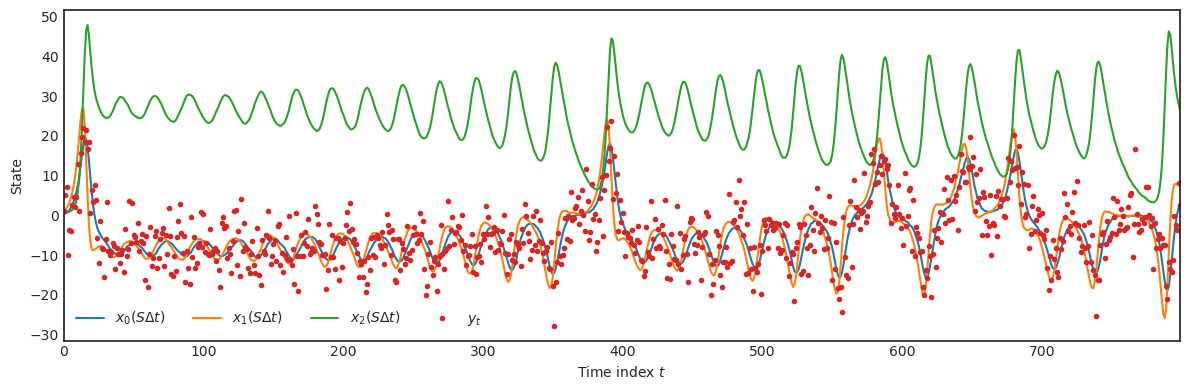

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(observation_time_indices, state_sequence)
ax.plot(observation_time_indices, observation_sequence, '.')
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
_ = ax.set_xlim(0, num_observation_time - 1)
ax.legend(['$x_0(S\Delta t)$', '$x_1(S\Delta t)$', '$x_2(S\Delta t)$', '$y_t$'], ncol=4)
fig.tight_layout()

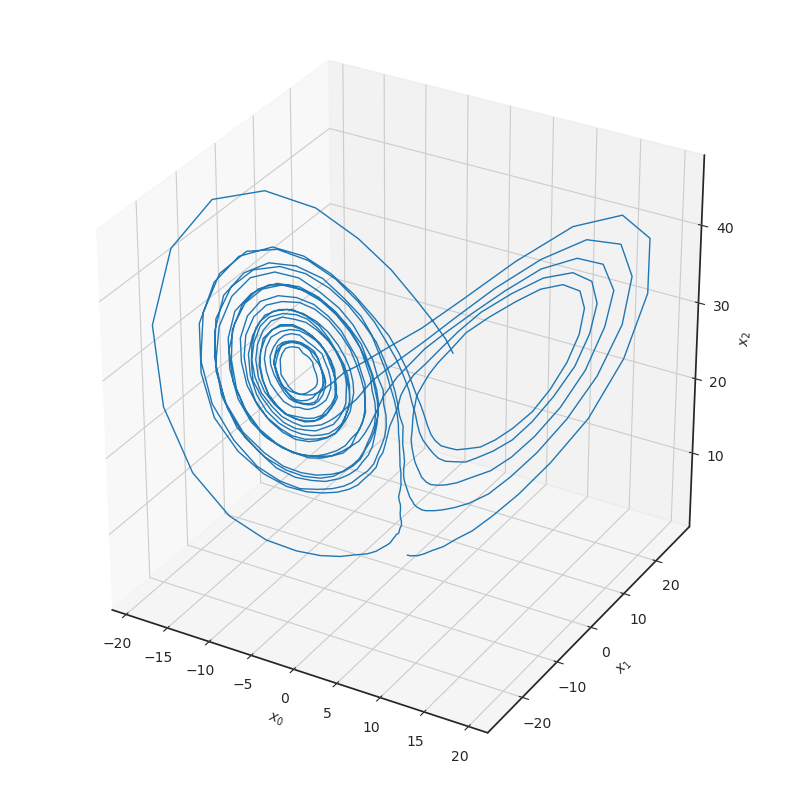

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.plot(*state_sequence.T, '-', lw=1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
fig.tight_layout()

### Infer state from observations

In [7]:
def plot_results(results, observation_time_indices, state_sequence=None, 
                 plot_particles=False, plot_region=True, 
                 particle_skip=2, trace_alpha=0.5):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 9))
    for i, ax in zip(range(3), axes):
        ax.plot(results['state_mean_sequence'][:, i], 'g-', lw=1, label='Est. mean')
        if plot_region:
            ax.fill_between(
                observation_time_indices,
                results['state_mean_sequence'][:, i] - 3 * results['state_std_sequence'][:, i],
                results['state_mean_sequence'][:, i] + 3 * results['state_std_sequence'][:, i],
                alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
            )
        if plot_particles:
            lines = ax.plot(
                observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, i], 
                'r-', lw=0.25, alpha=trace_alpha)
            lines[0].set_label('Particles')
        if state_sequence is not None:
            ax.plot(observation_time_indices, state_sequence[:, i], 'k--', label='Truth')
        ax.set_ylabel('$x_{0}$'.format(i))
        ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

In [2]:
from IPython.display import Image

### Kalman filter

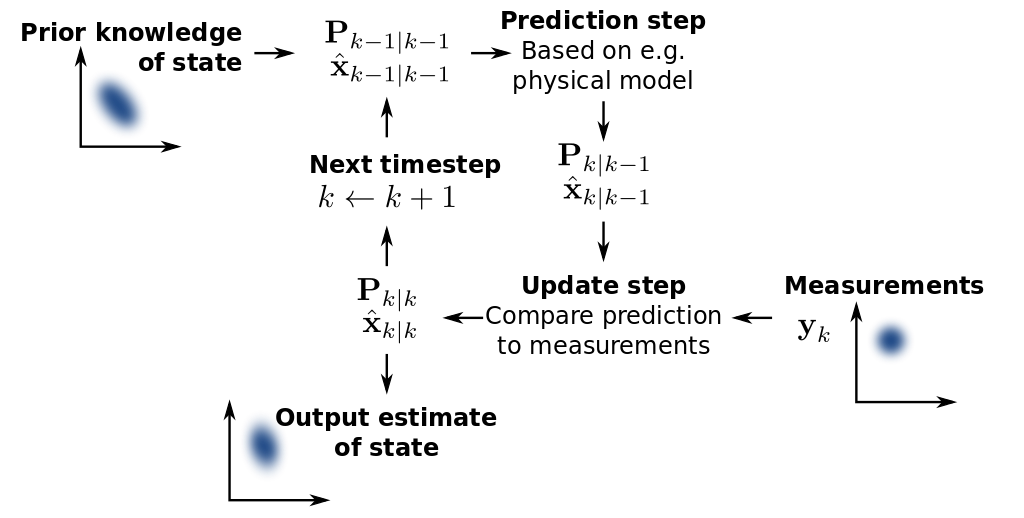

In [5]:
Image(filename='/opt/notebooks/static/Basic_concept_of_Kalman_filtering.png') 

References:

1. Kalman, R. E. (1960). A new approach to linear filtering and prediction problems. Transactions of the ASME -- Journal of Basic Engineering, Series D, 82, pp. 35--45.

In [8]:
fkf = filters.FunctionKalmanFilter()

In [9]:
results_fkf = fkf.filter(
    model, observation_sequence, observation_time_indices, rng=rng)

Filtering: 100%|██████████|800/800 [00:00<00:00, 2425.34time-steps/s]

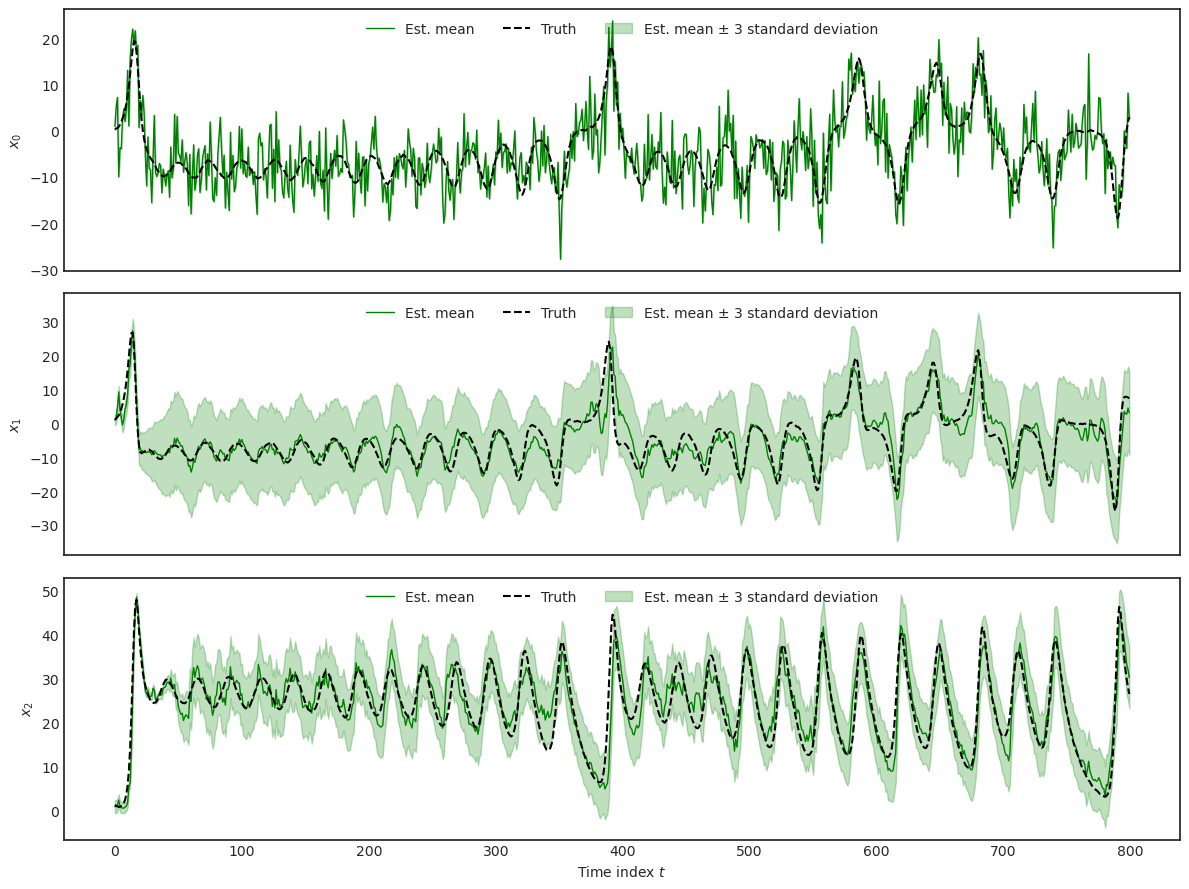

In [10]:
fig, axes = plot_results(results_fkf, observation_time_indices, state_sequence)

### Ensemble Kalman filter (perturbed observations)

Ensemble Kalman filter with perturbed observations.

The filtering distribution at each observation time index is approximated by alternating propagating an ensemble of state particles forward through time under the model dynamics and linearly transforming the ensemble according to a Monte Carlo estimate of the Kalman filter assimilation update due to the observations at the current time index. Here a 'perturbed observation' ensemble Kalman filter assimilation update is used with an observation particle sampled for each state particle from the conditional distribution on the observation given the state, and these observation particles as well as the original state particles used to approximate the covariance and mean statistics used in the Kalman update.

References:

Evensen, G. (1994). Sequential data assimilation with nonlinear quasi-geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research, 99 (C5), pp. 143--162

Burgers, G.,van Leeuwen, P. J. and Evensen, G. (1998). Analysis scheme in the ensemble Kalman filter. Monthly Weather Review, (126) pp 1719--1724.

In [11]:
enkf = filters.EnsembleKalmanFilter()

In [12]:
results_enkf = enkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:00<00:00, 1614.05time-steps/s]

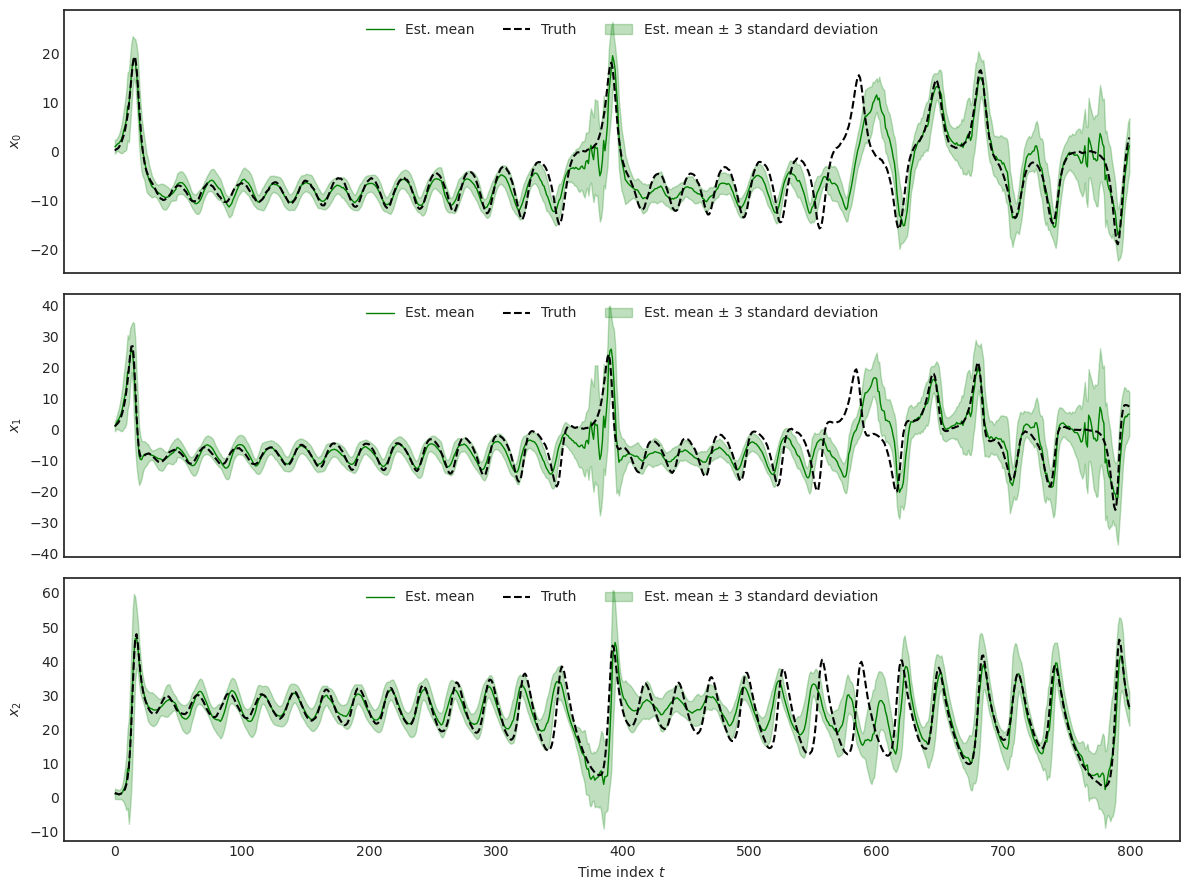

In [13]:
fig, axes = plot_results(results_enkf, observation_time_indices, state_sequence)

### Ensemble Transform Kalman filter (deterministic square root)

Ensemble Kalman filter with deterministic matrix square root updates.

The filtering distribution at each observation time index is approximated by alternating propagating an ensemble of state particles forward through time under the model dynamics and linearly transforming the ensemble according to a Monte Carlo estimate of the Kalman filter assimilation update due to the observations at the current time index. Here a 'square-root' ensemble Kalman filter assimilation update is used, which requires that the model has Gaussian observation noise with a known covariance, but compared to the 'perturbed observation' variant avoids the additional variance associated with sampling pseudo-observations.

References:

1. Bishop, C. H. Etherton, B. J. and  Majumdar, S. J. (2001). Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects.Mon. Wea. Rev., 129, 420–436.
2. M. K. Tippett, J. L. Anderson, C. H. Bishop, T. M. Hamill, and J. S. Whitaker, Ensemble square root filters, Monthly Weather Review, 131 (2003), pp. 1485--1490.

In [14]:
etkf = filters.EnsembleTransformKalmanFilter()

In [15]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:00<00:00, 1530.94time-steps/s]

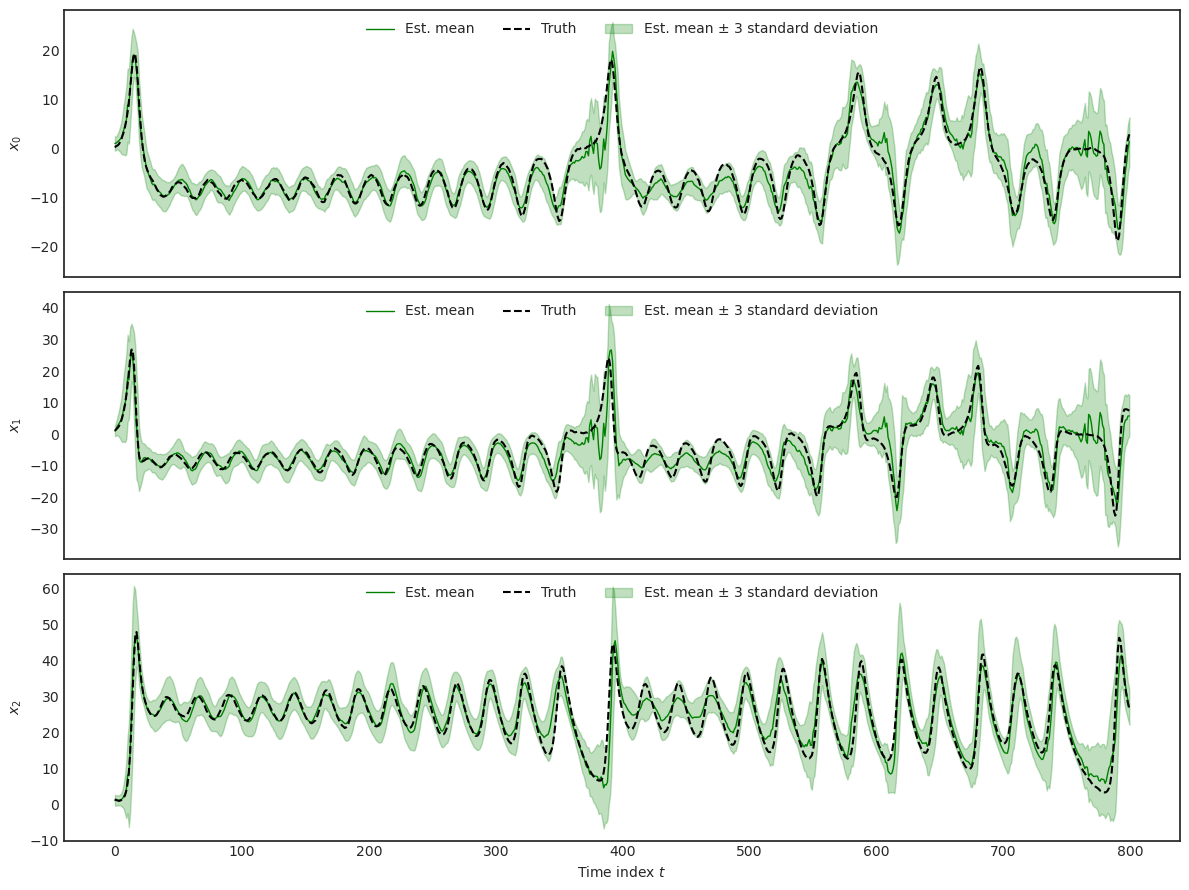

In [16]:
fig, axes = plot_results(results_etkf, observation_time_indices, state_sequence)